# CNN with Image Augmentation (PyTorch)
This notebook is based on the book Hands-On Transfer Learning with Python by Dipanjan Sarkar, Raghav Bali, and Tamoghna Ghosh.
Similar way as before, but now with image augmentation using torchvision.transforms.
The following code demonstrates how to create a Convolutional Neural Network (CNN) model using PyTorch with image augmentation.
Realizing the training on the Cats vs Dogs dataset.


In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from datasets import load_dataset

c:\Users\stiva001\AppData\Local\anaconda3\envs\ml_class\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Constants and device

In [2]:
IMG_DIM = (128, 128)
BATCH_SIZE = 10
EPOCHS = 50
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)

Using device: cuda


## Load Hugging Face dataset and create Dataset wrapper

In [3]:
from datasets import concatenate_datasets

# Load dataset (this will download if not present)
ds_full = load_dataset("microsoft/cats_vs_dogs")['train']

# Select 500 cats and 500 dogs
cats = ds_full.filter(lambda x: x['labels'] == 0).select(range(500))
dogs = ds_full.filter(lambda x: x['labels'] == 1).select(range(500))

# Concatenate and shuffle
subset = concatenate_datasets([cats, dogs]).shuffle(seed=42)

# Split into train and validation
ds = subset.train_test_split(test_size=0.2, seed=42)
hf_train = ds['train']
hf_val = ds['test']
print('HF train size:', len(hf_train), 'HF val size:', len(hf_val))

HF train size: 800 HF val size: 200


In [4]:
class HFImageDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.ds = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[int(idx)]
        img = item['image']
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)
        img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = int(item['labels'])
        return img, torch.tensor(label, dtype=torch.float32)

print('HF train size:', len(hf_train), 'HF val size:', len(hf_val))

HF train size: 800 HF val size: 200


## Transforms and DataLoaders

Different of the previous notebook, we now apply image augmentations using `torchvision.transforms`.

Previously we just resized the images and converted them to tensors.
``` python

train_transform = transforms.Compose([
    transforms.Resize(IMG_DIM),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize(IMG_DIM),
    transforms.ToTensor(),
])
```

Now we can add more transformations to augment the data.
The training transform can include more augmentations like random flips, rotations, color jitter, etc.


In [5]:
train_transform = transforms.Compose([
    transforms.Resize(IMG_DIM),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(IMG_DIM, scale=(0.6,1.0)),
    transforms.ToTensor(),
])
val_transform = transforms.Compose([
    transforms.Resize(IMG_DIM),
    transforms.ToTensor(),
])

train_dataset = HFImageDataset(hf_train, transform=train_transform)
val_dataset = HFImageDataset(hf_val, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print('Train dataset size:', len(train_dataset), '\tValidation dataset size:', len(val_dataset))

Train dataset size: 800 	Validation dataset size: 200


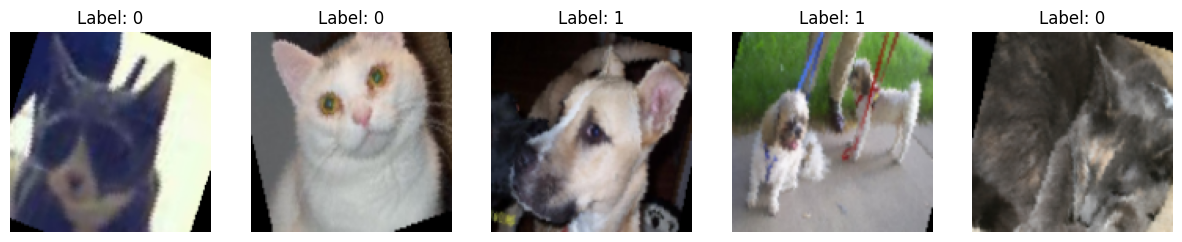

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img, label = train_dataset[i]
    img_np = img.permute(1, 2, 0).numpy()
    axes[i].imshow(img_np)
    axes[i].set_title(f'Label: {int(label)}')
    axes[i].axis('off')
plt.show()

## Model definition

In [7]:
class AugCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (IMG_DIM[0]//8) * (IMG_DIM[1]//8), 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.squeeze(1)

model = AugCNN().to(DEVICE)
model

AugCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

## Training loop

In [11]:
def train_model(model, train_loader, val_loader):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_losses, train_acc = [], []
    val_losses, val_acc = [], []

    for epoch in range(1, EPOCHS+1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for imgs, labels in train_loader:
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            preds = (outputs.detach() > 0.5).float()
            correct += (preds == labels).sum().item()
            total += imgs.size(0)
        train_losses.append(running_loss/total)
        train_acc.append(correct/total)

        model.eval()
        with torch.no_grad():
            vloss = 0.0
            vcorrect = 0
            vtotal = 0
            for imgs, labels in val_loader:
                imgs = imgs.to(DEVICE)
                labels = labels.to(DEVICE)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                vloss += loss.item() * imgs.size(0)
                preds = (outputs > 0.5).float()
                vcorrect += (preds == labels).sum().item()
                vtotal += imgs.size(0)
            val_losses.append(vloss/vtotal if vtotal else 0)
            val_acc.append(vcorrect/vtotal if vtotal else 0)

        if epoch % 10 == 0 or epoch == 1:
            print(f'Epoch {epoch}/{EPOCHS} - loss: {train_losses[-1]:.4f} - acc: {train_acc[-1]:.4f} - val_loss: {val_losses[-1]:.4f} - val_acc: {val_acc[-1]:.4f}')

    return train_acc, val_acc, train_losses, val_losses

In [12]:
# Do the training
train_acc, val_acc, train_losses, val_losses = train_model(model, train_loader, val_loader)

Epoch 1/50 - loss: 0.6906 - acc: 0.5300 - val_loss: 0.6793 - val_acc: 0.5400
Epoch 10/50 - loss: 0.6696 - acc: 0.5988 - val_loss: 0.6961 - val_acc: 0.5450
Epoch 20/50 - loss: 0.6522 - acc: 0.6300 - val_loss: 0.6848 - val_acc: 0.5800
Epoch 30/50 - loss: 0.6295 - acc: 0.6550 - val_loss: 0.6312 - val_acc: 0.6000
Epoch 40/50 - loss: 0.5679 - acc: 0.7013 - val_loss: 0.6793 - val_acc: 0.6350
Epoch 50/50 - loss: 0.5276 - acc: 0.7150 - val_loss: 0.7227 - val_acc: 0.6500


## Plot and save model

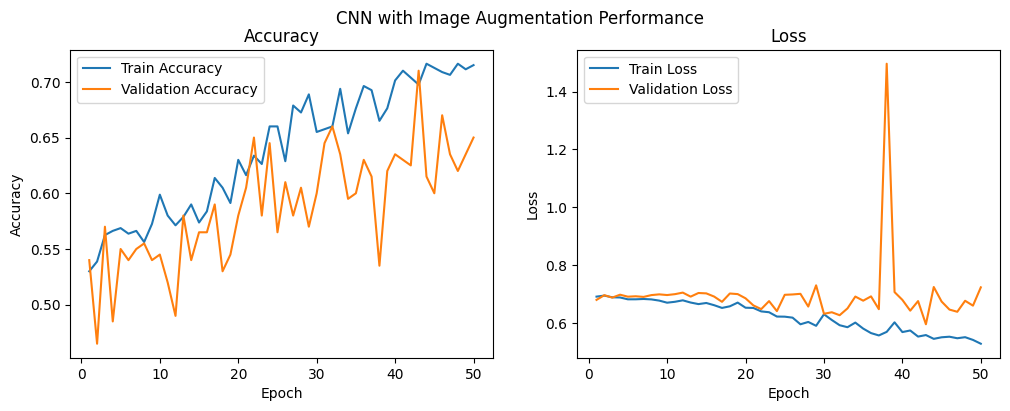

Model saved to CTRL_OA_cnn_img_aug_pytorch.pth


In [ ]:
epochs = list(range(1, EPOCHS+1))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(epochs, train_acc, label='Train Accuracy')
ax1.plot(epochs, val_acc, label='Validation Accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, train_losses, label='Train Loss')
ax2.plot(epochs, val_losses, label='Validation Loss')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.suptitle('CNN with Image Augmentation Performance')
plt.show()

torch.save(model.state_dict(), 'CTRL_OA_cnn_img_aug_pytorch.pth')
print('Model saved to CTRL_OA_cnn_img_aug_pytorch.pth')

# Exercise

Change the image augmentations in the training transform to see how they affect model performance. Here are some ideas:
- Add `transforms.RandomHorizontalFlip()`
- Add `transforms.RandomRotation(degrees=15)`
- Add `transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)`

## Exercise Solution

<details>
  <summary>Click to show/hide the solution</summary>
  
``` python
train_transform_v2 = transforms.Compose([
    transforms.RandomResizedCrop(IMG_DIM, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),
    transforms.ToTensor(),
])
```
  
</details>

In [ ]:
# Create the new data transform
train_transform_v2 = #####

In [15]:
train_dataset_v2 = HFImageDataset(hf_train, transform=train_transform_v2)

train_loader_v2 = DataLoader(train_dataset_v2, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

print('Train dataset size:', len(train_dataset_v2))

Train dataset size: 800


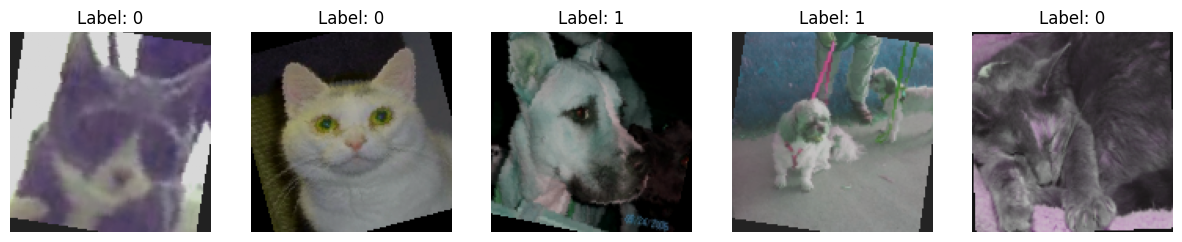

In [17]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img, label = train_dataset_v2[i]
    img_np = img.permute(1, 2, 0).numpy()
    axes[i].imshow(img_np)
    axes[i].set_title(f'Label: {int(label)}')
    axes[i].axis('off')
plt.show()

In [18]:
aug_model = AugCNN().to(DEVICE)

In [19]:
train_acc_v2, val_acc_v2, train_losses_v2, val_losses_v2 = train_model(aug_model, train_loader_v2, val_loader)

Epoch 1/50 - loss: 0.7104 - acc: 0.4738 - val_loss: 0.6877 - val_acc: 0.5350
Epoch 10/50 - loss: 0.6958 - acc: 0.5262 - val_loss: 0.6944 - val_acc: 0.4700
Epoch 20/50 - loss: 0.6657 - acc: 0.5938 - val_loss: 0.6938 - val_acc: 0.5450
Epoch 30/50 - loss: 0.6402 - acc: 0.6450 - val_loss: 0.7019 - val_acc: 0.5750
Epoch 40/50 - loss: 0.6120 - acc: 0.6663 - val_loss: 0.6854 - val_acc: 0.6000
Epoch 50/50 - loss: 0.5662 - acc: 0.7025 - val_loss: 0.6672 - val_acc: 0.6600


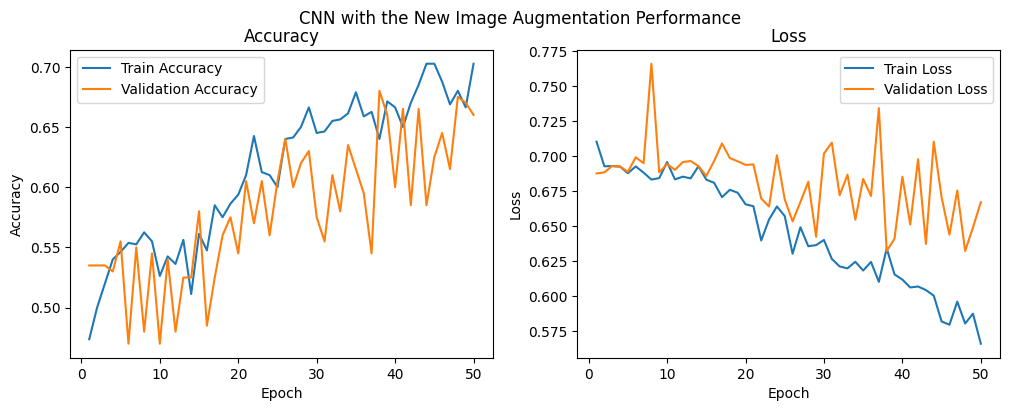

In [20]:
epochs = list(range(1, EPOCHS+1))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(epochs, train_acc_v2, label='Train Accuracy')
ax1.plot(epochs, val_acc_v2, label='Validation Accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, train_losses_v2, label='Train Loss')
ax2.plot(epochs, val_losses_v2, label='Validation Loss')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.suptitle('CNN with the New Image Augmentation Performance')
plt.show()